In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [5]:
import numpy as np
import time
import pathlib
import numpy.typing as npt
from typing import Optional
from dataclasses import dataclass, field

In [13]:
from rxrmask.core import (
    Atom,
    Structure,
    FormFactorModel,
    FormFactorFile,
    FormFactorLocalDB,
    ParametersContainer,
    create_compound,
    load_reflectivity_scans,
    ReflectivityScan,
    EnergyScan,
)
from rxrmask.utils import (
    plot_reflectivity,
    plot_energy_scan,
    plot_density_profile,
    get_density_profile_from_element_data,
    plot_formfactor_object,
plot_density_profile_atoms_layers
)
from rxrmask.backends import (
    PRReflectivityBackend,
    PRParallelReflectivityBackend,
)

In [14]:
o_ff = FormFactorLocalDB(element="O", is_magnetic=False)
sr_ff = FormFactorLocalDB(element="Sr", is_magnetic=False)
ti_ff = FormFactorLocalDB(element="Ti", is_magnetic=False)


o_file_ff = FormFactorFile(path="/Users/niaggar25/Downloads/Experimental RXR data/O.ff")
sr_file_ff = FormFactorFile(path="/Users/niaggar25/Downloads/Experimental RXR data/Sr.ff")
ti_file_ff = FormFactorFile(path="/Users/niaggar25/Downloads/Experimental RXR data/Ti.ff")

o_atom = Atom(
    Z=8,
    name="O",
    ff=o_ff,
)
sr_atom = Atom(
    Z=38,
    name="Sr",
    ff=sr_ff,
)
ti_atom = Atom(
    Z=22,
    name="Ti",
    ff=ti_ff,
)
o_file_atom = Atom(
    Z=8,
    name="O",
    ff=o_file_ff,
)
sr_file_atom = Atom(
    Z=38,
    name="Sr",
    ff=sr_file_ff,
)
ti_file_atom = Atom(
    Z=22,
    name="Ti",
    ff=ti_file_ff,
)

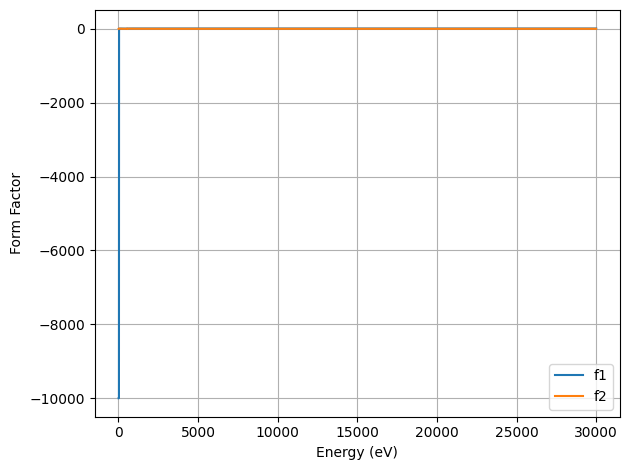

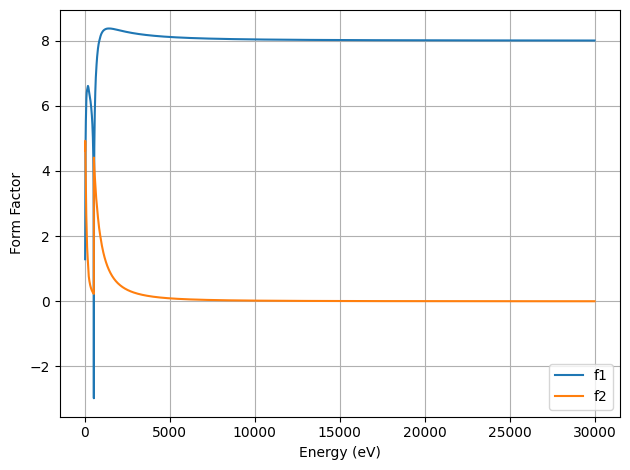

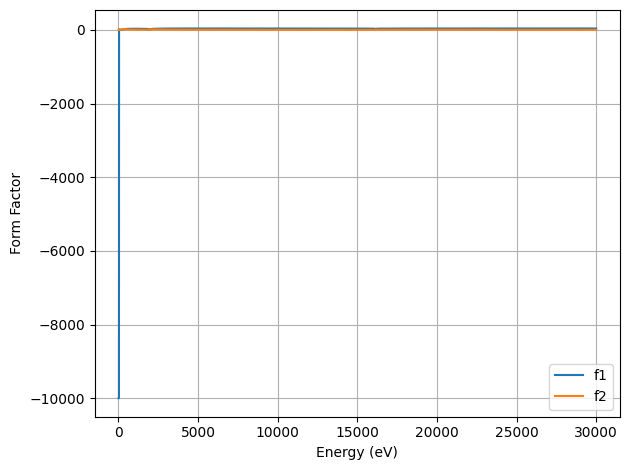

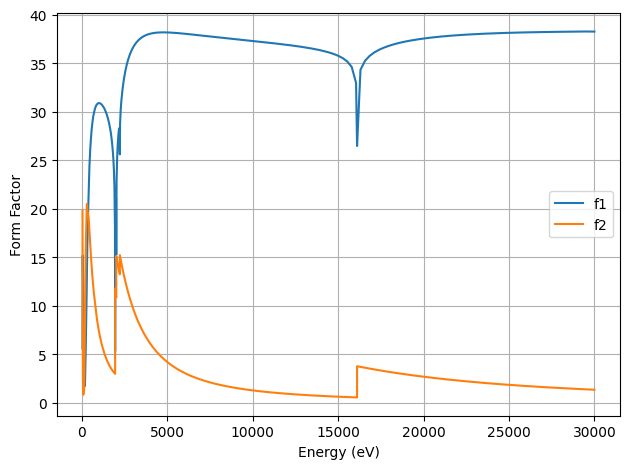

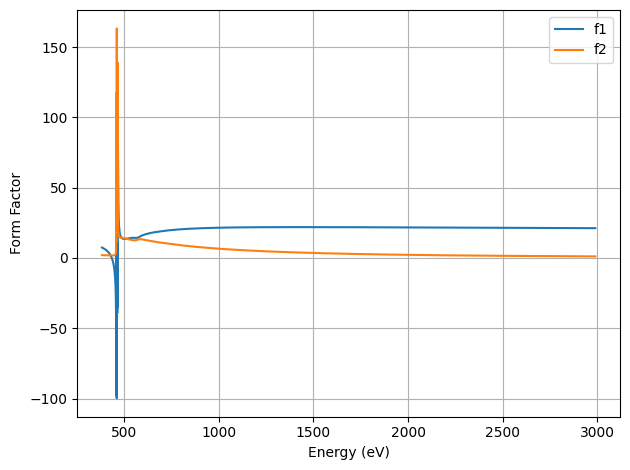

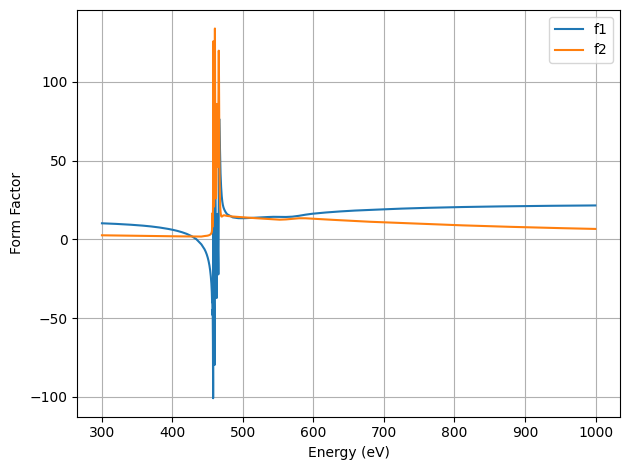

In [12]:
plot_formfactor_object(o_atom.ff)
plot_formfactor_object(o_file_atom.ff)
plot_formfactor_object(sr_atom.ff)
plot_formfactor_object(sr_file_atom.ff)
plot_formfactor_object(ti_atom.ff)
plot_formfactor_object(ti_file_atom.ff)

Initial parameters:
Current params: [5.6, 23.0, 4.12, 4.0]
SrTiO3-crystal-roughness: 5.6
SrTiO3-film-thickness: 23.0
SrTiO3-film-density: 4.12
SrTiO3-film-roughness: 4.0


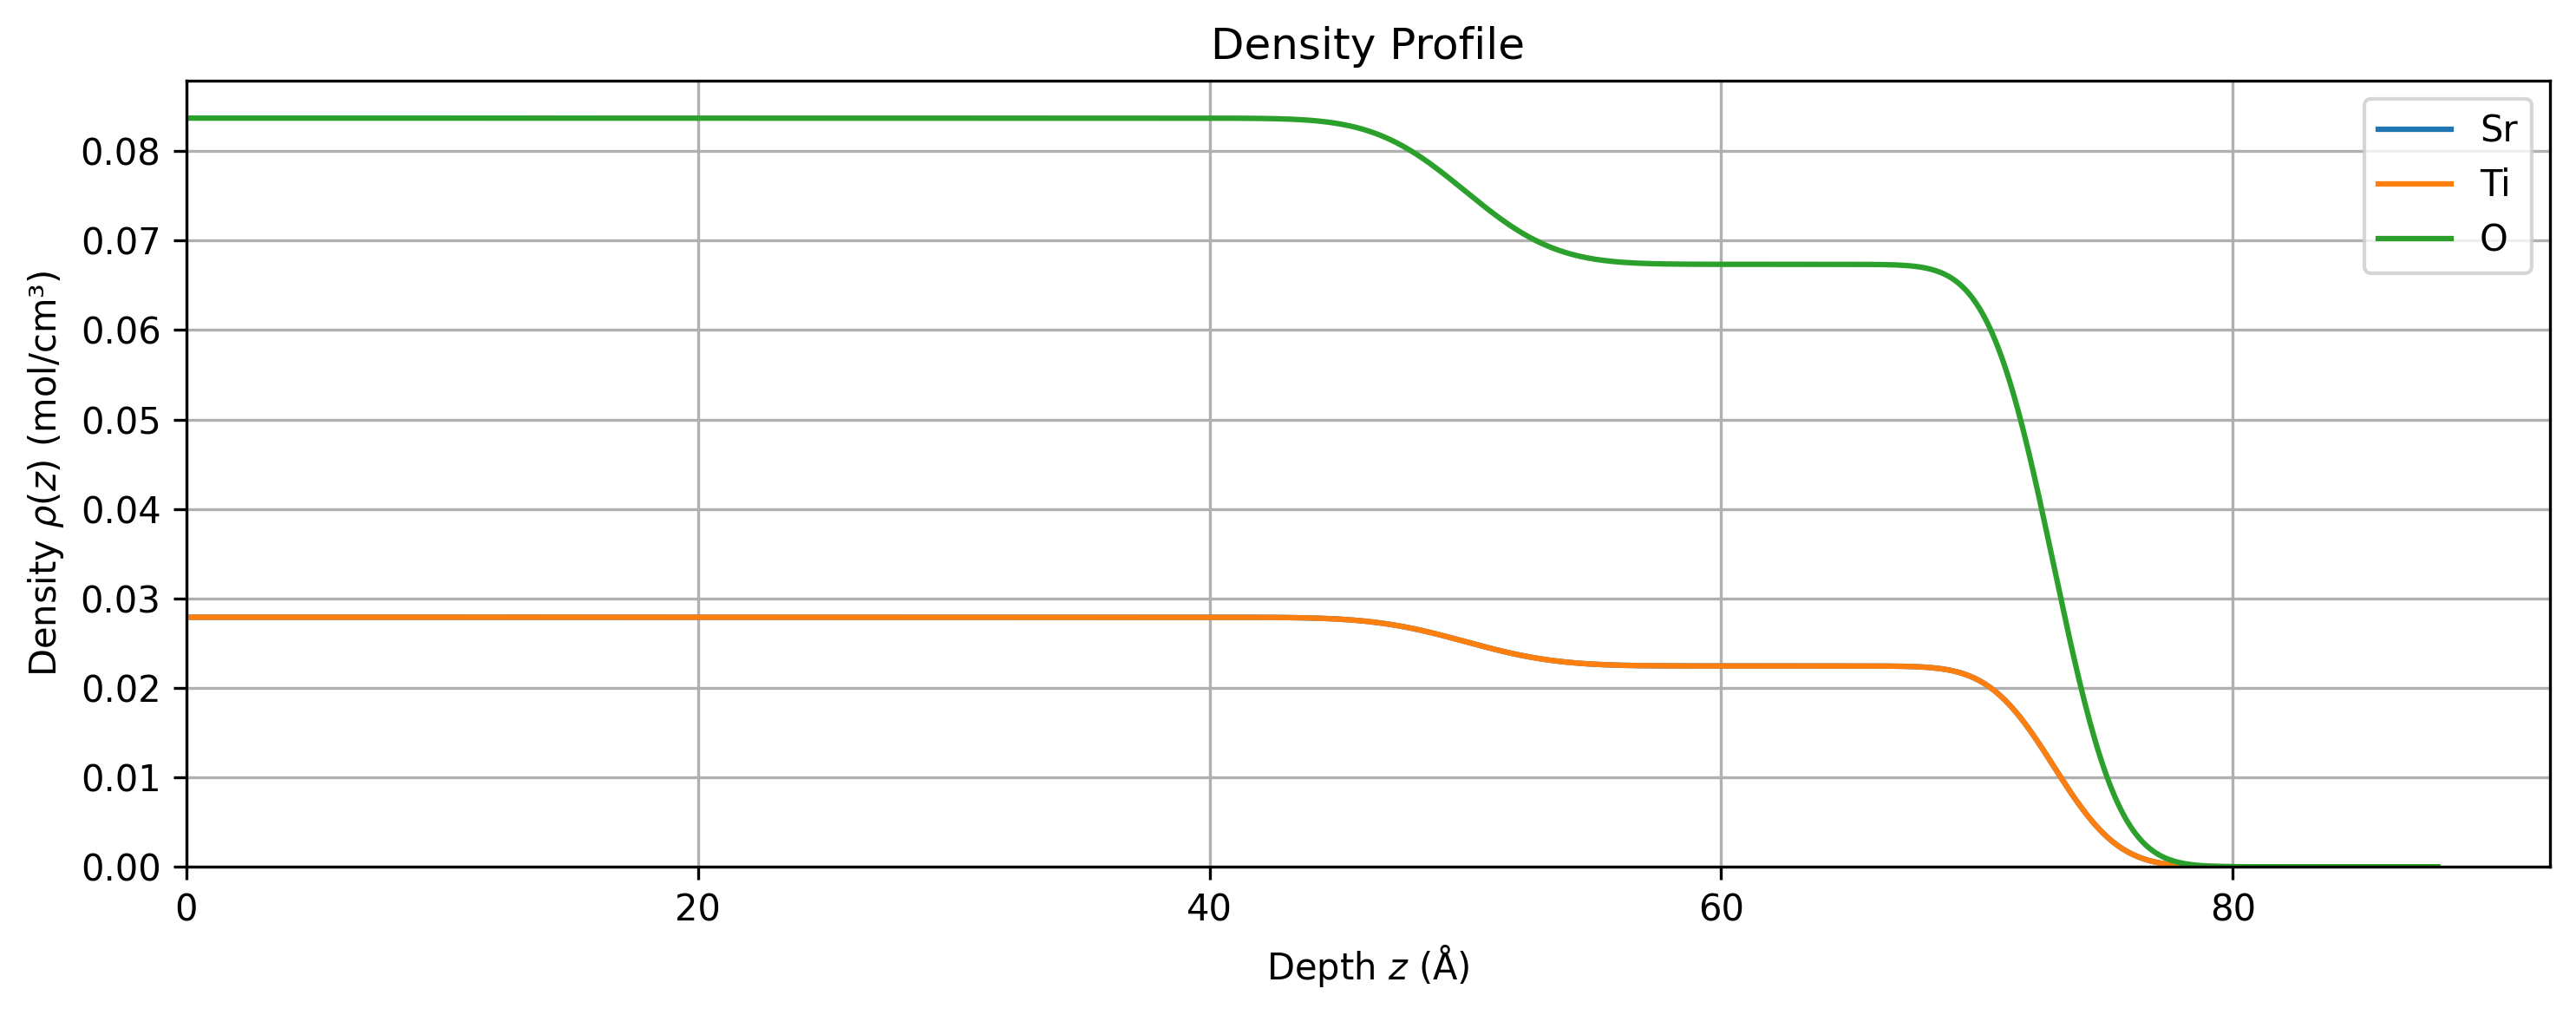

In [5]:
parameters_container = ParametersContainer()
crystal = create_compound(
    parameters_container=parameters_container,
    name="SrTiO3-crystal",
    formula="Sr:1,Ti:1,O:3",
    thickness=50.0,
    density=5.12,
    atoms=[sr_atom, ti_atom, o_atom],
    roughness=5.6,
    prev_roughness=0.0,
    linked_prev_roughness=False,
)
film = create_compound(
    parameters_container=parameters_container,
    name="SrTiO3-film",
    formula="Sr:1,Ti:1,O:3",
    thickness=23.0,
    density=4.12,
    atoms=[sr_atom, ti_atom, o_atom],
    roughness=4.0,
    prev_roughness=0.0,
    linked_prev_roughness=True,
)

struc = Structure(name="SrTiO3-struc", n_compounds=2, params_container=parameters_container)
struc.add_compound(0, crystal)
struc.add_compound(1, film)
struc.validate_compounds()
struc.create_layers(step=0.1)

crystal.roughness.fit = True
crystal.roughness.lower = 0.0
crystal.roughness.upper = 10.0

film.thickness.fit = True
film.thickness.lower = 20.0
film.thickness.upper = 30.0

film.roughness.fit = True
film.roughness.lower = 0.0
film.roughness.upper = 10.0

film.density.fit = True
film.density.lower = 4.0
film.density.upper = 6.0
struc.update_layers()

def print_parameters(params_container):
    params_vals = params_container.get_fit_vector()
    print(f"Current params: {params_vals}")
    for param in params_container.parameters:
        if param.fit:
            print(f"{param.name}: {param.value}")


print("Initial parameters:")
print_parameters(parameters_container)
plot_density_profile_atoms_layers(struc.atoms_layers)

In [6]:
backend = PRReflectivityBackend()

Theta = np.linspace(0.1, 89.1, num=200)
Energies = np.linspace(450, 600, num=200)
energies = [456.8, 457.0, 457.2, 457.4, 457.6, 457.8, 458.0]
thetas = [6.0, 7.5, 9.0, 12.0, 20.0]

experimental_rscans = []
for energy in energies:
    qz = np.sin(Theta * np.pi / 180) * (energy * 0.001013546143)
    r_dat = backend.compute_reflectivity(structure=struc, qz=qz, energy=energy)
    scan = ReflectivityScan(
        name=f"Scan_{energy:.1f} eV",
        energy_eV=energy,
        pol="s",
        qz=r_dat.qz,
        R=r_dat.R_s,
        bounds=[(min(r_dat.qz), max(r_dat.qz))],
        weights=[1.0],
    )
    experimental_rscans.append(scan)

experimental_escans = []
for theta in thetas:
    r_dat = backend.compute_energy_scan(structure=struc, energy_range=Energies, theta=theta)
    scan = EnergyScan(
        name=f"Scan_{theta:.1f} deg",
        theta_deg=theta,
        pol="s",
        E_eV=Energies,
        R=r_dat.R_s,
        bounds=[(min(Energies), max(Energies))],
        weights=[1.0],
    )
    experimental_escans.append(scan)

Reflectivity calculation time: 0.0155 seconds


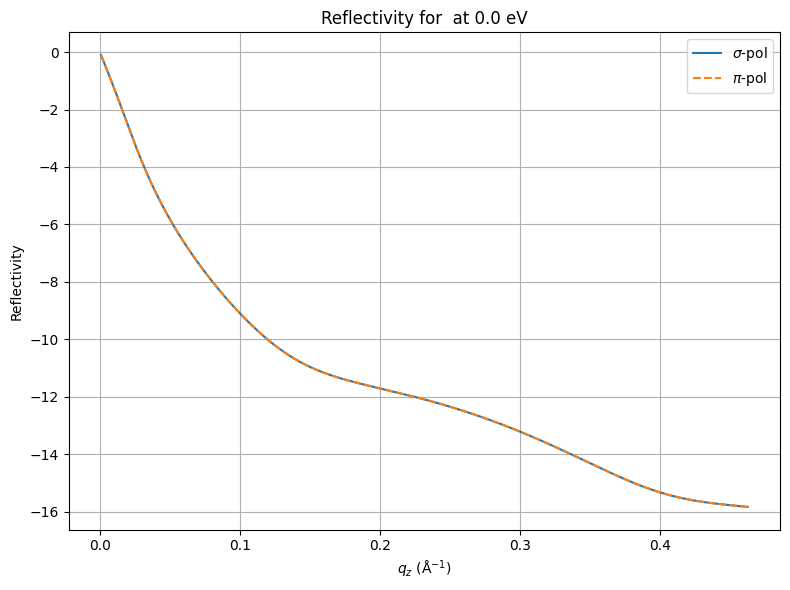

In [7]:
backend = PRReflectivityBackend()

E_eV = 456.8
Theta = np.linspace(0.1, 89.1, num=200)
qz = np.sin(Theta * np.pi / 180) * (E_eV * 0.001013546143)

init_time = time.perf_counter()
initial_ref = backend.compute_reflectivity(structure=struc, qz=qz, energy=E_eV)
end_time = time.perf_counter()
print(f"Reflectivity calculation time: {end_time - init_time:.4f} seconds")
plot_reflectivity(initial_ref.qz, np.log(initial_ref.R_s), np.log(initial_ref.R_s), initial_ref.energy, "")


In [ ]:
experimental_scans = load_reflectivity_scans(
    path='/Users/niaggar25/Downloads/Experimental RXR data/B074_AScans.dat',
    initial_name='B074_AScans',
)

i = 0
exp_data_test = experimental_scans[i]
plot_reflectivity(exp_data_test.qz, np.log(exp_data_test.R), np.log(exp_data_test.R), exp_data_test.energy_eV, f"{exp_data_test.pol}")

In [8]:
from rxrmask.optimization import fit_differential_evolution, fit_least_squares, FitContext, FitTransform, TVRegularizer

Initial parameters:
Current params: [0.0, 26.0, 5.2, 0.0]
SrTiO3-crystal-roughness: 0.0
SrTiO3-film-thickness: 26.0
SrTiO3-film-density: 5.2
SrTiO3-film-roughness: 0.0


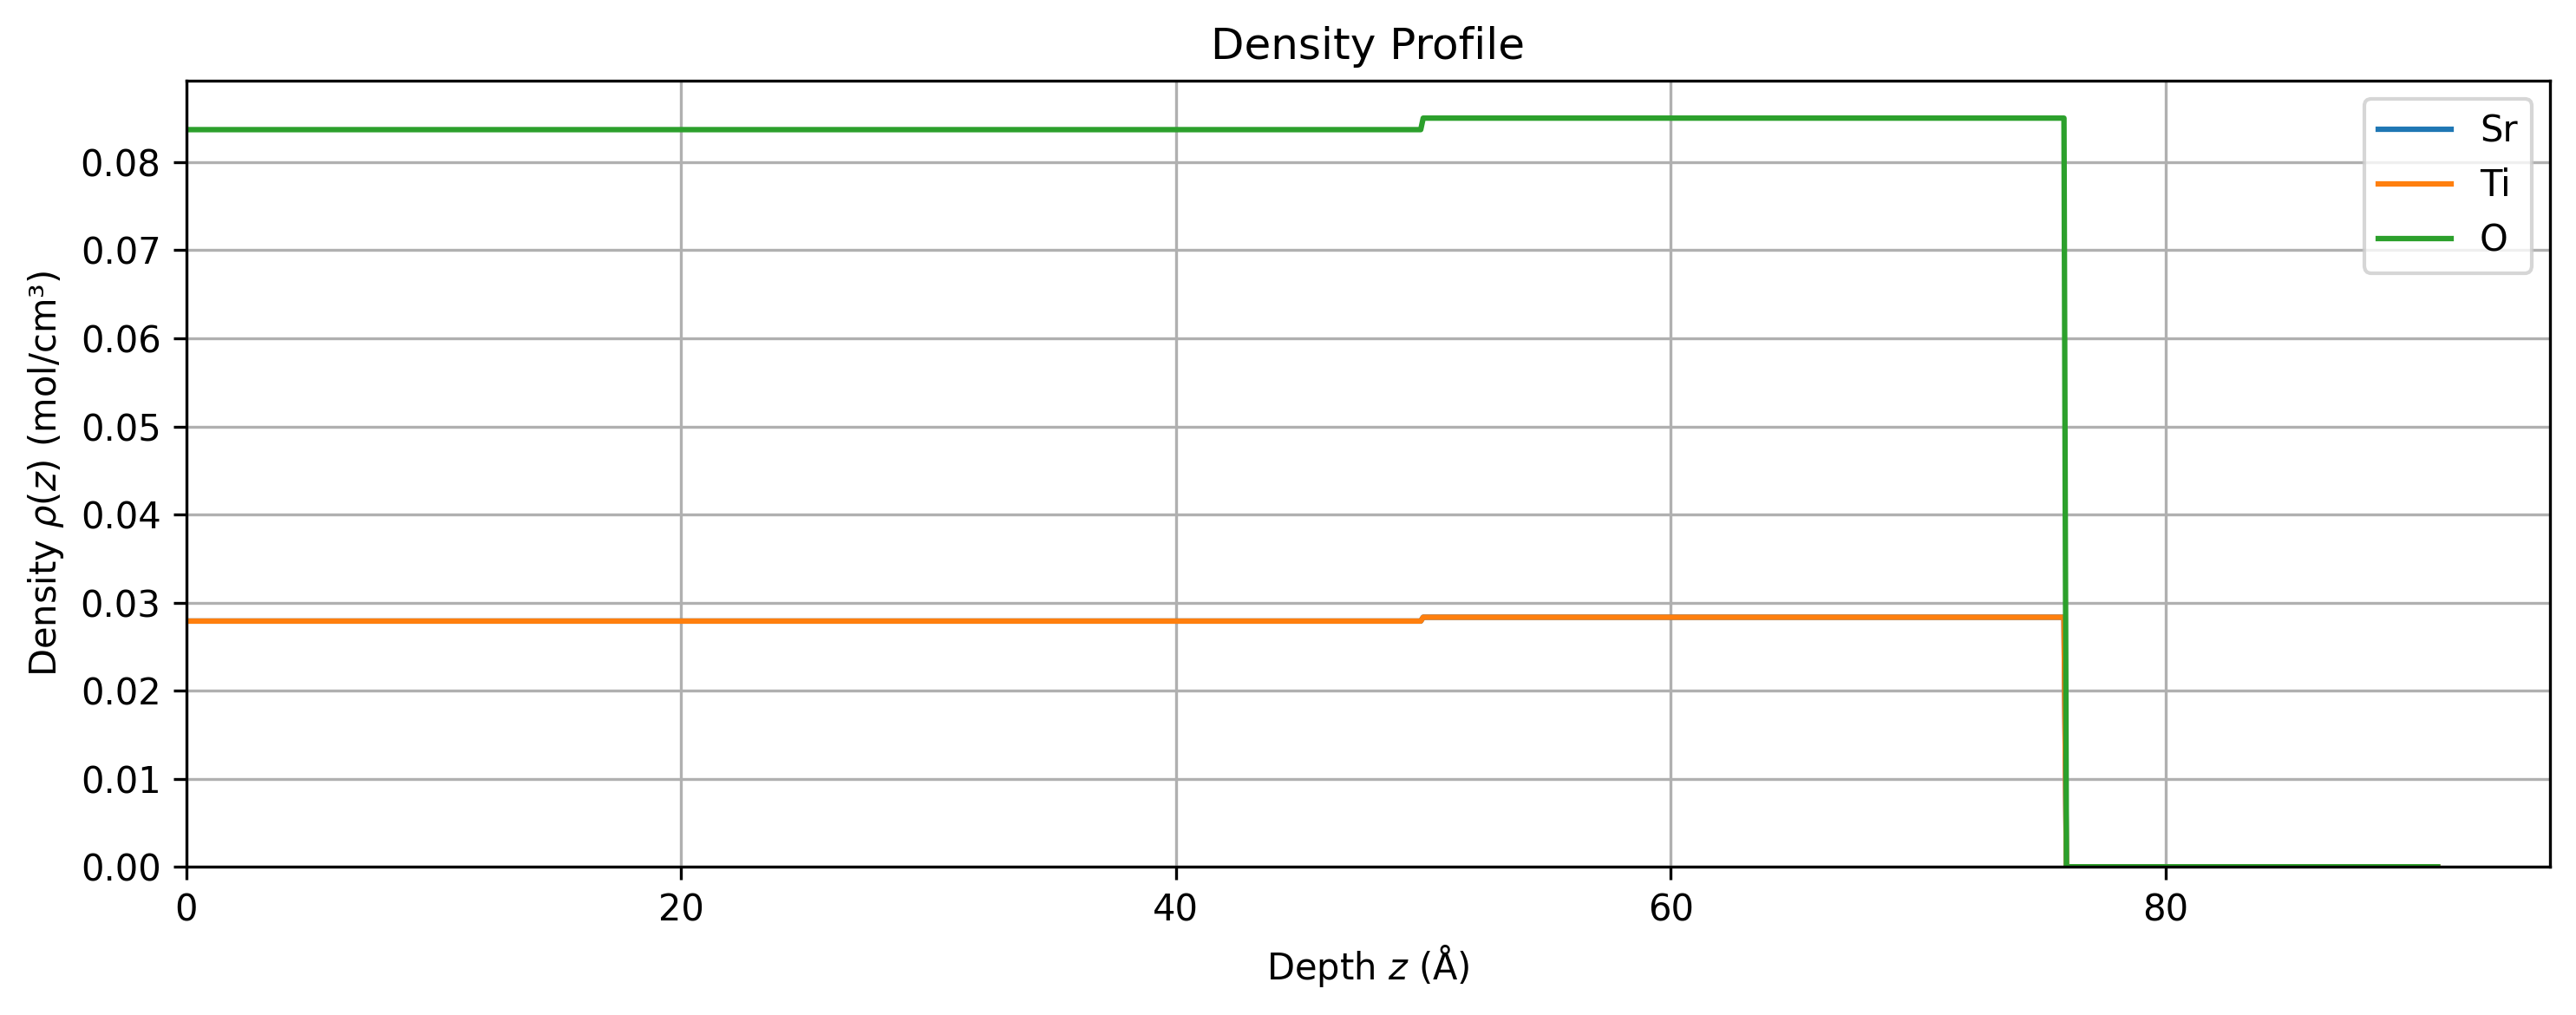

In [9]:
crystal.roughness.set(0.0)
film.thickness.set(26.0)
film.roughness.set(0.0)
film.density.set(5.2)
struc.update_layers()


print("Initial parameters:")
print_parameters(parameters_container)
plot_density_profile_atoms_layers(struc.atoms_layers)

Total cost: 191.697488 (objective=chi2)
Total cost: 328.572348 (objective=chi2)
Total cost: 198.068786 (objective=chi2)
Total cost: 228.309986 (objective=chi2)
Total cost: 56.916606 (objective=chi2)
Total cost: 71.146829 (objective=chi2)
Total cost: 75.226558 (objective=chi2)
Total cost: 31.731569 (objective=chi2)
Total cost: 123.052316 (objective=chi2)
Total cost: 297.856671 (objective=chi2)
Total cost: 52.109717 (objective=chi2)
Total cost: 66.002490 (objective=chi2)
Total cost: 30.017154 (objective=chi2)
Total cost: 369.115423 (objective=chi2)
Total cost: 34.245207 (objective=chi2)
Total cost: 120.385548 (objective=chi2)
Total cost: 120.717659 (objective=chi2)
Total cost: 65.573224 (objective=chi2)
Total cost: 62.596156 (objective=chi2)
Total cost: 7.948646 (objective=chi2)
Total cost: 57.238013 (objective=chi2)
Total cost: 38.694597 (objective=chi2)
Total cost: 284.051098 (objective=chi2)
Total cost: 54.899546 (objective=chi2)
Total cost: 242.893312 (objective=chi2)
Total cost: 173

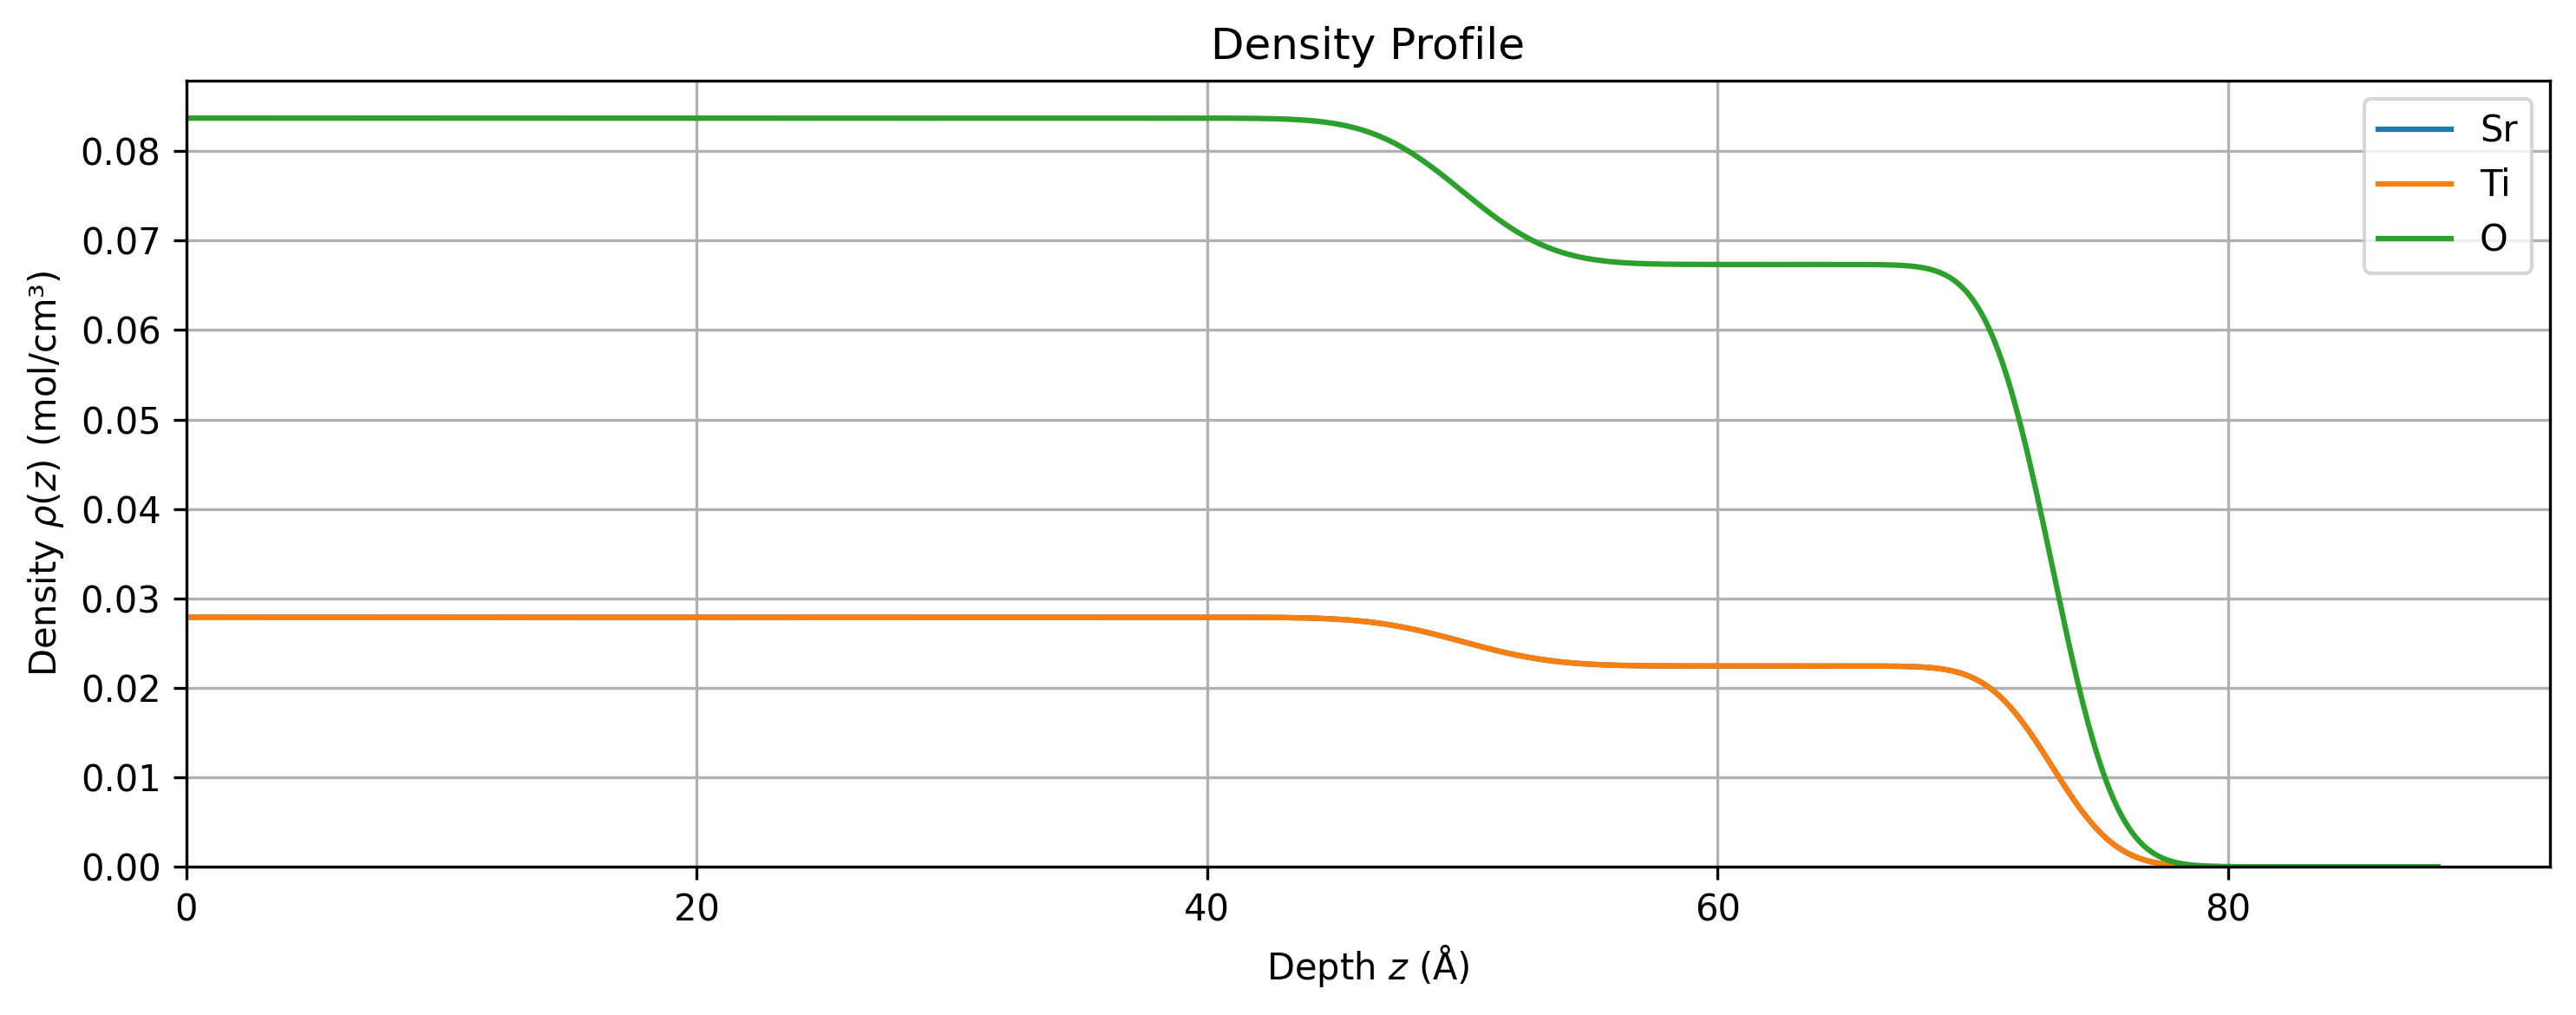

In [10]:
context = FitContext(
    backend=backend,
    structure=struc,
    transform=FitTransform(r_scale="ln"),
    tv=TVRegularizer(),
    objective="chi2",
)
parameters = [
    param for param in parameters_container.parameters if param.fit
]

res = fit_differential_evolution(
    x0=parameters_container.get_fit_vector(),
    params=parameters,
    ctx=context,
    ref_scans=experimental_rscans,
    en_scans=experimental_escans,
)

print(res)
print("Final parameters:")
print_parameters(parameters_container)
plot_density_profile_atoms_layers(struc.atoms_layers)